
**<h1>Medical Imaging:</h1>**
**<h1>Super Pixel SLIC Segmentation for Capillary Images</h1>**

In [1217]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.color import rgb2lab
from skimage import measure, util, exposure, segmentation, color, img_as_float

from skimage.morphology import disk
from skimage.filters import median, gaussian


from sklearn.cluster import KMeans

In [1218]:
class ReadImg:
    
    '''
    Read images from a folder and identify marked image from the original,
    ReadImg method returns marked_img, original_img in green channels

    ReadImg expect three params :
    - folder path string
    - 3 letter file name prefix string e.g ('N1a')
    - Marked filename letter identifiers string e.g ('Natif')
    '''

    def __init__(self, folder_path, file_prefix, id_str):
        self.folder_path = folder_path
        self.file_prefix = file_prefix # prefix example 'N1a'
        self.id_str = id_str
        self.images = self.read_images()
        self.original_img, self.marked_img,  = self.identifier()
    
    def read_images(self):
        self.image_paths = []
        for file in os.listdir(self.folder_path):
            if file.startswith(self.file_prefix):
                self.image_paths.append(os.path.join(self.folder_path, file))
        
        if len(self.image_paths) != 2:
            print("Error: Could not find two images starting with '{}'".format(self.file_prefix))
            return
        
        images = []
        for path in self.image_paths:
            img = cv2.imread(path)
            images.append(img)
        
        return images
    
    def identifier(self):
        marked_img = None
        original_img = None
        
        for i, img in enumerate(self.images):
            if self.id_str in self.image_paths[i]:
                original_img = img
            else:
                marked_img = img

        # 1 for green channel
        # return  original_img[:,:,1] , marked_img[:,:,1]
        
        # x = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
        # y = cv2.cvtColor(marked_img, cv2.COLOR_BGR2GRAY)
        # return x, y
        
        return  original_img , marked_img

In [1219]:
class Roi:
    '''
    Crop region of interest using difference between the two images, hence the line in the marked image
    expect 3 arguments; original and marked image, crop method

    Crop method to pass ->  
    1: bilateral_along_line,
    2: upside half along line,
    3: downside half along line,
    4: diagnal box crop
    '''

    def __init__(self, a_img, b_img, method):
        self.a_img = a_img
        self.b_img = b_img
        self.method = method
        self.cropped = self.crop_method()
     
    def crop_method(self):
        a_gray = cv2.cvtColor(self.a_img, cv2.COLOR_BGR2GRAY)
        b_gray = cv2.cvtColor(self.b_img, cv2.COLOR_BGR2GRAY)

        diff =cv2.subtract(b_gray, a_gray)
        diff[diff>=1]=255
        diff = cv2.bilateralFilter(diff, 5, 70,75)

        lines = cv2.HoughLinesP(diff, 3, theta=3.14/180, threshold=10, minLineLength=200, maxLineGap=60)
        x1,y1,x2,y2=lines[0,0]
        halfwidth = 150
        k=halfwidth/np.sqrt(1+((x2-x1)/(y2-y1))**2)#ratio

        if self.method == '1' :
            x_1l,y_1l,x_1r,y_1r,x_2l,y_2l,x_2r,y_2r = x1-k,y1+k*((x2-x1)/(y2-y1)),x1+k,y1+k*((x2-x1)/(y1-y2)), x2-k,y2+k*((x2-x1)/(y2-y1)),x2+k,y2+k*((x2-x1)/(y1-y2))
            h = int(np.sqrt((1+((x2-x1)/(y2-y1))**2))*k*2)
            w = int(np.sqrt((x2-x1)**2+(y2-y1)**2))

        if self.method == '2' :
            x_1l,y_1l,x_1r,y_1r,x_2l,y_2l,x_2r,y_2r = x1-k,y1+k*((x2-x1)/(y2-y1)),x1,y1, x2-k,y2+k*((x2-x1)/(y2-y1)),x2,y2
            h = int(np.sqrt((1+((x2-x1)/(y2-y1))**2))*k)
            w = int(np.sqrt((x2-x1)**2+(y2-y1)**2))
        
        if self.method == '3' :
            x_1l,y_1l,x_1r,y_1r,x_2l,y_2l,x_2r,y_2r = x1,y1,x1+k,y1+k*((x2-x1)/(y1-y2)), x2,y2,x2+k,y2+k*((x2-x1)/(y1-y2))
            h = int(np.sqrt((1+((x2-x1)/(y2-y1))**2))*k)
            w = int(np.sqrt((x2-x1)**2+(y2-y1)**2))

        if self.method == '4' :
            x_1l,y_1l,x_1r,y_1r,x_2l,y_2l,x_2r,y_2r = x1,y2,x1,y1,x2,y2,x2,y1
            h = int(np.abs(y2 - y1))
            w = int(np.abs(x2 - x1))
        
        mask = np.zeros_like(self.b_img).astype(np.uint8)
        cv2.fillPoly(mask, [np.array([[int(x_1l),int(y_1l)],[int(x_2l),int(y_2l)],[int(x_2r),int(y_2r)],[int(x_1r),int(y_1r)]])], (255,255,255))
        #a_result = cv2.bitwise_and(self.a_img, mask)
        b_result = cv2.bitwise_and(self.b_img, mask)# on image without marker 
        dst_points = np.array([(0, 0), ( 0,h), (w, h), (w, 0)], dtype=np.float32)
        src_points = np.array([(int(x_1l),int(y_1l)), (int(x_1r),int(y_1r)), (int(x_2r),int(y_2r)),(int(x_2l),int(y_2l))], dtype=np.float32)

        matrix = cv2.getPerspectiveTransform(src_points, dst_points)
        a_warped = cv2.warpPerspective(self.a_img, matrix, (w,h))            
        a_warped = cv2.cvtColor(a_warped, cv2.COLOR_BGR2RGB)

        # diff2= np.invert(diff)
        return a_warped, self.a_img, self.b_img, diff, mask, b_result 

In [1220]:
class Preprocess:
    def __init__(self, image):
        self.image = image
        self.pre = self.pre()

    def pre(self):
        self.green = self.image[:,:,1]
        
        clahe = cv2.createCLAHE(clipLimit=15, tileGridSize=(5, 5))
        self.eq= clahe.apply(self.green)

        self.g = cv2.GaussianBlur(self.eq, (9, 9), 1)
        #self.g = cv2.GaussianBlur(self.g, (9, 9), 1)
        
        self.denoised = cv2.medianBlur(self.g, 11)
       
        kernel1 = np.ones((3, 3), np.uint8)
        self.op = cv2.morphologyEx(self.denoised, cv2.MORPH_OPEN, kernel1)

        return self.green, self.eq, self.g, self.denoised, self.op
    
    

class Segmentation:
    def __init__(self, image ):
        self.seg_img = image
        self.segment = self.segment()

    def segment(self):
        
        self.adaptive_gaussian = cv2.adaptiveThreshold(self.seg_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15,2)
        self.adaptive_mean = cv2.adaptiveThreshold(self.seg_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 2)

        kernel_3 = np.ones((3, 3), np.uint8)
        kernel_7 = np.ones((6, 5), np.uint8)

        self.g_dilating = cv2.dilate(self.adaptive_gaussian, kernel_3, iterations=1)
        self.g_closing = cv2.morphologyEx(self.g_dilating, cv2.MORPH_OPEN, kernel_7)

        return self.adaptive_mean, self.adaptive_gaussian, self.g_dilating, self.g_closing


    def count_true_capillaries(self, binary_image, pixel_size_threshold):
        self.binary_image = binary_image
        
        self.inverted = util.invert(binary_image)
        self.pixel_size_threshold = pixel_size_threshold

        plt.imshow(self.binary_image)
        plt.axis('off')
        plt.show()

        # Apply connected component analysis
        labeled_image = measure.label(self.inverted, connectivity=2)
        regions = measure.regionprops(labeled_image)


        props = measure.regionprops(labeled_image)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(self.binary_image, cmap='gray')
        for prop in props:
            minr, minc, maxr, maxc = prop.bbox
            rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        ax.set_title("Binary Image with Bounding Boxes")
        plt.axis('off')
        plt.show()


        self.filtered_image = np.zeros_like(self.binary_image)  # New image to store filtered components
        self.num_bounding_boxes = 0

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(self.binary_image, cmap='gray')

        for region in regions:
            if region.area >= self.pixel_size_threshold:
                minr, minc, maxr, maxc = region.bbox
                rect0 = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, edgecolor='r', facecolor='none')
                ax.add_patch(rect0)
                self.filtered_image[minr:maxr, minc:maxc] = self.inverted[minr:maxr, minc:maxc]
                self.num_bounding_boxes += 1

        self.capillaries_present = util.invert(self.filtered_image)

        ax.set_title("Capillary Feature Extraction")
        plt.axis('off')
        plt.show()

        plt.imshow(self.capillaries_present, cmap="gray")
        plt.axis('off')
        plt.show()

        print("Number of True Capillaries Present is:", self.num_bounding_boxes)
        return self.capillaries_present




In [1221]:
class Kmeans:
    def __init__(self, img, num_clusters):
        self.img = img
        self.num_clusters = num_clusters
        self.k_means = self.kmeans_segment()

    def kmeans_segment(self):
        # Flatten the image into a 2D array of pixel intensities
        pixels = self.img.reshape((-1, 1))
        
        # Convert the data type to float32 for K-means clustering
        pixels = np.float32(pixels)
        
        # Define the criteria for K-means clustering
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)
        
        # Perform K-means clustering
        _, labels, centers = cv2.kmeans(pixels, self.num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        
        # Convert the labels to 8-bit for visualization
        labels = labels.astype(np.uint8)
        
        # Reshape the labels to match the self.img shape
        segmented = labels.reshape(self.img.shape)
        
        return segmented

In [1222]:
class OTSU:
    def __init__(self, img):
        print(img)
        self.img = img
        self.h,self.w = self.img.shape
        self.otsu = self.otsu_segment()
    def otsu_segment(self):
        threshold = skimage.filters.threshold_otsu(self.img)
        binary_image = self.img > threshold
        temp_ = np.zeros((self.h,self.w))
        temp_[binary_image] = 255
        binary_image = temp_.astype(np.uint8)
        return binary_image

In [1223]:
class Plot:
    def __init__(self):
        pass

    def plot_2_images(self, images, titles):
        fig, axes = plt.subplots(1, 2, figsize=(15, 7))

        for i, ax in enumerate(axes.flat):
          
            each_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

            ax.imshow(each_image)
            ax.set_title(titles[i])
            ax.axis('off')

        plt.show()
        
    
    def plot_3_images(self, images, titles):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for i, ax in enumerate(axes.flat):
          
            each_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

            ax.imshow(each_image)
            ax.set_title(titles[i])
            ax.axis('off')

        plt.show()

    def plot_4_images(self, images, titles, cvt=None): 
        fig, axes = plt.subplots(2, 2, figsize=(15, 5))

        for i, ax in enumerate(axes.flat):
            
            if cvt is None:
                each_image = images[i]
            else:
                each_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

            ax.imshow(each_image)
            ax.set_title(titles[i])
            ax.axis('off')

    def plot_4_images_gray(self, images, titles, cvt=None): 
        fig, axes = plt.subplots(2, 2, figsize=(15, 5))

        for i, ax in enumerate(axes.flat):
            
            if cvt is None:
                each_image = images[i]
            else:
                each_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

            ax.imshow(each_image, cmap="gray")
            ax.set_title(titles[i])
            ax.axis('off')

        plt.show()
    
    def add(a, b=None):
        if b is None:
            return a + 10
        else:
            return a + b

 
    def plot_6_images(self, images, titles):
        fig, axes = plt.subplots(2, 3, figsize=(15, 7))
        fig.subplots_adjust(hspace=0.3)

        for i, ax in enumerate(axes.flat):
            
            each_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
            
            ax.imshow(each_image)
            ax.set_title(titles[i])
            ax.axis('off')

        plt.show()

In [1224]:
path = 'data/N1'
prefix = 'N1b'
id_str = 'Natif'


a = ReadImg(path, prefix, id_str)
marked_img = a.marked_img
original_img = a.original_img

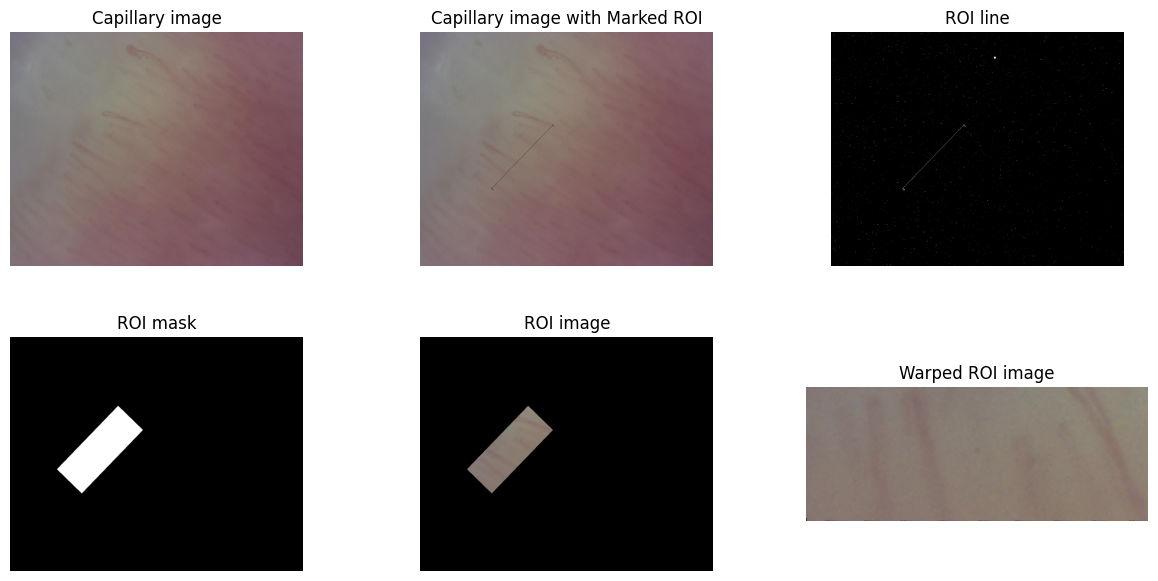

In [1225]:
'''
Create a Roi object and crop the original image
'''
b = Roi(marked_img, original_img, '2')
warped, marked, original, difference, mask, result  = b.cropped

# Display images 
image_list = [original, marked, difference, mask, result, cv2.cvtColor(warped, cv2.COLOR_RGB2BGR)]
title_list = ['Capillary image', 'Capillary image with Marked ROI', 'ROI line', 'ROI mask', 'ROI image', 'Warped ROI image' ]

p = Plot()
p.plot_6_images(image_list, title_list)

In [1226]:
#Use Green channel of cropped Image
# crop = warped[:, :, 1]
warped_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)


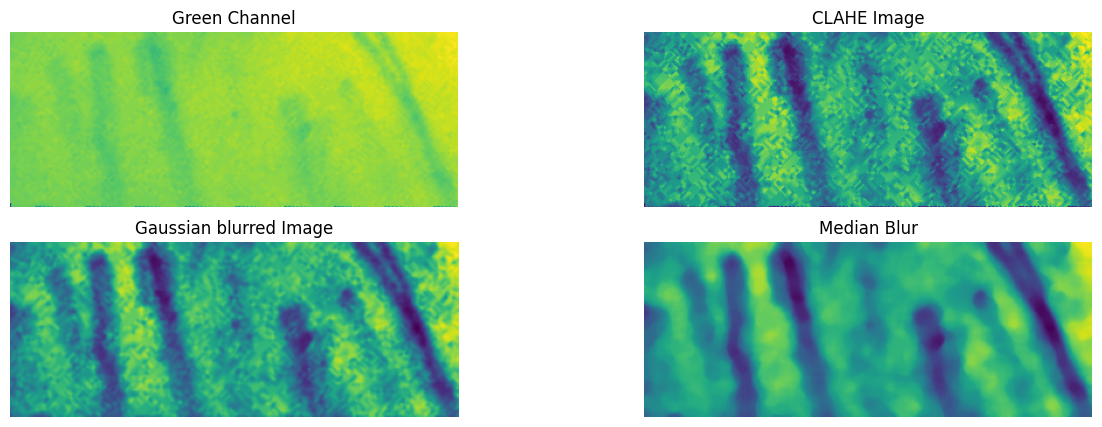

In [1227]:
e = Preprocess(warped)
pre_img = e.pre

green_img, clahe_img, gaussian_blur, median_img, open_morph = pre_img

image_list = [green_img, clahe_img, gaussian_blur, median_img]
title_list = ['Green Channel', 'CLAHE Image', 'Gaussian blurred Image', 'Median Blur']
p.plot_4_images(image_list, title_list)





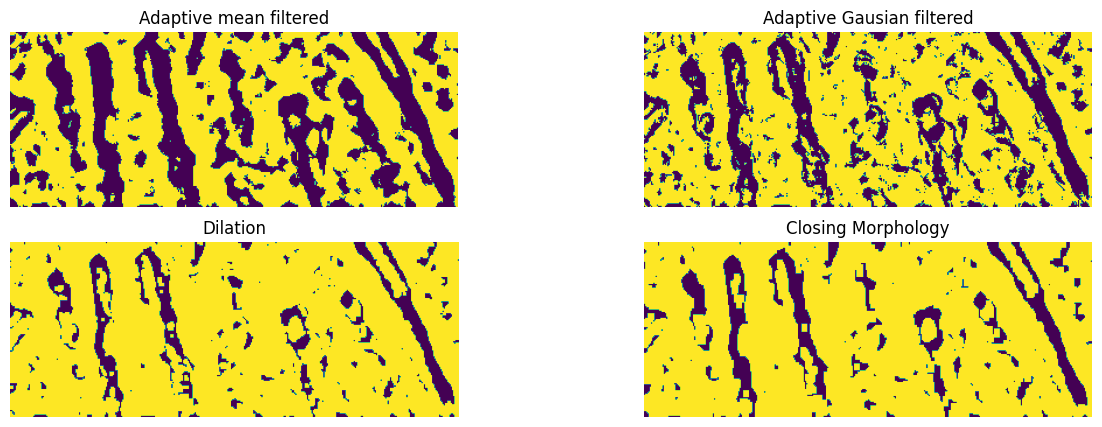

In [1228]:
# count_segments = e.count_true_capillaries(g_closing, 300)

f = Segmentation(open_morph)
adaptive_mean, adaptive_g, g_dilating, g_closing = f.segment

image_list = [adaptive_mean, adaptive_g, g_dilating, g_closing]
title_list = ['Adaptive mean filtered', 'Adaptive Gausian filtered', 'Dilation', 'Closing Morphology']
p.plot_4_images(image_list, title_list)

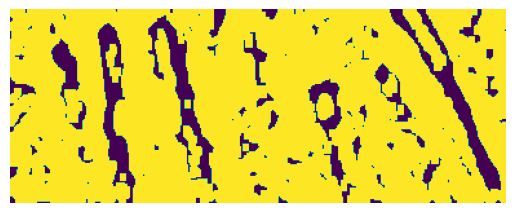

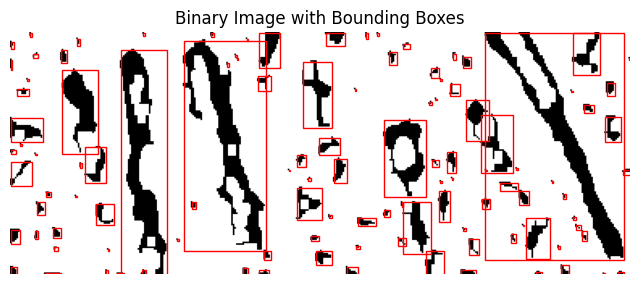

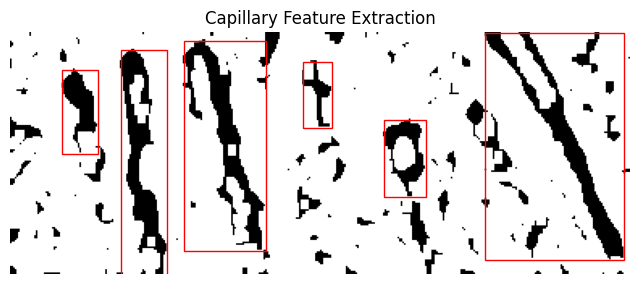

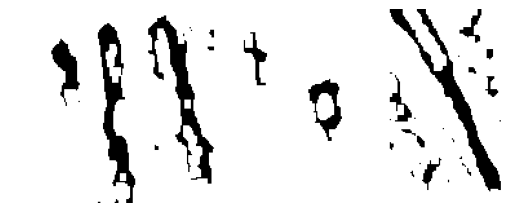

Number of True Capillaries Present is: 6


In [1229]:
count_segments = f.count_true_capillaries(g_closing, 200)

# image_list = [adaptive_mean, adaptive_g, g_dilating, g_closing]
# title_list = ['Adaptive mean filtered', 'Adaptive Gausian filtered', 'Dilation', 'Closing Morphology']
# p.plot_4_images(image_list, title_list)